In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [5]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
%pwd

/content/gdrive/My Drive/Kaggle


'/content/gdrive/My Drive/Kaggle'

In [ ]:
%ls

kaggle.json  sample_submission.csv  test.csv  train.csv


In [26]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras
import sklearn
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from wordcloud import WordCloud, STOPWORDS


### Loading Data:

In [ ]:
#! pip install -q kaggle
#! kaggle competitions download -c nlp-getting-started

test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [13]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sub_sample = pd.read_csv("sample_submission.csv")

### Exploring Data:

In [ ]:
print("-------- Shapes --------")
print("Train set:", train.shape)
print("Test set:", test.shape)

-------- Shapes --------
Train set: (7613, 5)
Test set: (3263, 4)


In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
sub_sample.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [ ]:
train.duplicated().sum()

0

In [ ]:
train = train.drop_duplicates().reset_index(drop=True)

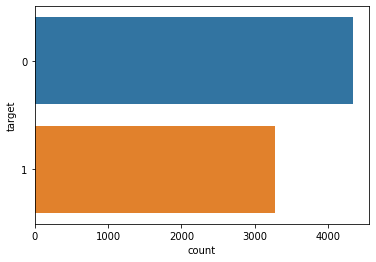

In [ ]:
#Visualizing class imbalance
sns.countplot(y=train.target);

In [ ]:
print("------ Null Values ------")
print("\n Train set:\n", train.isnull().sum())
print("\n Test set:\n",test.isnull().sum())

------ Null Values ------

 Train set:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

 Test set:
 id             0
keyword       26
location    1105
text           0
dtype: int64


### Keywords:

In [ ]:
print(train.keyword.nunique(),test.keyword.nunique())

221 221


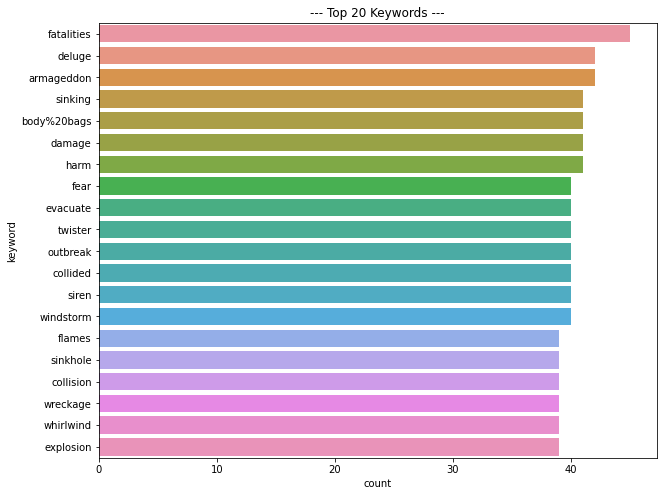

In [ ]:
#Most common keywords:
plt.figure(figsize=(10,8))
sns.countplot(y=train.keyword, order = train.keyword.value_counts().iloc[:20].index)
plt.title('--- Top 20 Keywords ---')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


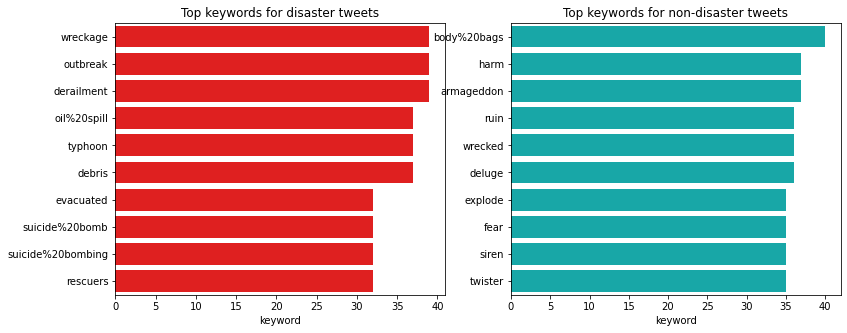

In [ ]:
kw_d = train[train.target==1].keyword.value_counts().head(10)
kw_nd = train[train.target==0].keyword.value_counts().head(10)

plt.figure(figsize=(13,5))
plt.subplot(121)
sns.barplot(kw_d, kw_d.index, color='r')
plt.title('Top keywords for disaster tweets')
plt.subplot(122)
sns.barplot(kw_nd, kw_nd.index, color='c')
plt.title('Top keywords for non-disaster tweets')
plt.show()

### Locations:

In [ ]:
print (train.location.nunique(), test.location.nunique())

3341 1602


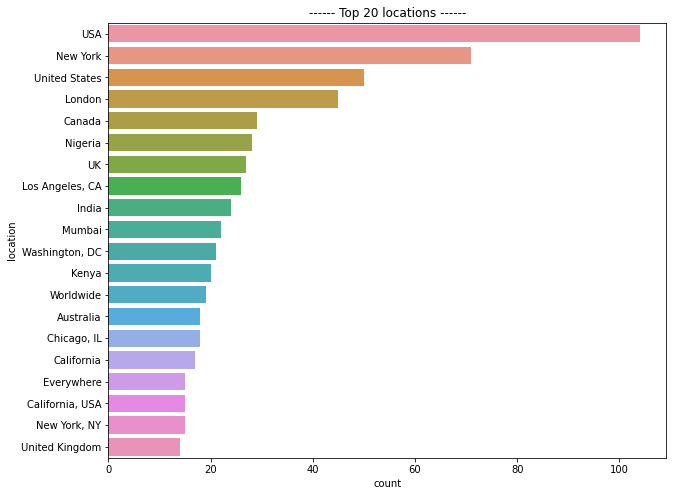

In [ ]:
# Most common locations
plt.figure(figsize=(10,8))
sns.countplot(y=train.location, order = train.location.value_counts().iloc[:20].index)
plt.title('------ Top 20 locations ------')
plt.show()

## Text cleaning

In [7]:
import re
from nltk import FreqDist, word_tokenize
from nltk.corpus import stopwords
import nltk
import spacy
sp = spacy.load('en_core_web_sm')
nltk.download('stopwords')
nltk.download('punkt')

nltk_st = stopwords.words('english')




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [14]:
def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    text = [word for word in word_tokenize(text) if not word.lower() in nltk_st] #Removing stopwords
    text = ' '.join(text)
    lemmatized = [word.lemma_ for word in sp(text)] #Lemmatizing
    text = ' '.join(lemmatized)
    text = text.translate(str.maketrans('', '', string.punctuation)) #Remove punctuations
    text = re.sub("\s+", ' ', text)  #Remove extra spaces

    return text

def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
    
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))
    
    return df
    
train = process_text(train)
test = process_text(test)

for df in [train, test]:
    df.drop(columns = ['location', 'keyword', 'id'], inplace = True)

In [15]:
train.head()

,text,target,text_clean,hashtags,mentions,links
0,Our Deeds are the Reason of this #earthquake M...,1,Deeds Reason earthquake May allah forgive PRON,earthquake,no,no
1,Forest fire near La Ronge Sask. Canada,1,forest fire near La Ronge Sask Canada,no,no,no
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,no,no,no
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...,wildfires,no,no
4,Just got sent this photo from Ruby #Alaska as ...,1,get send photo Ruby Alaska smoke wildfire pour...,Alaska wildfires,no,no


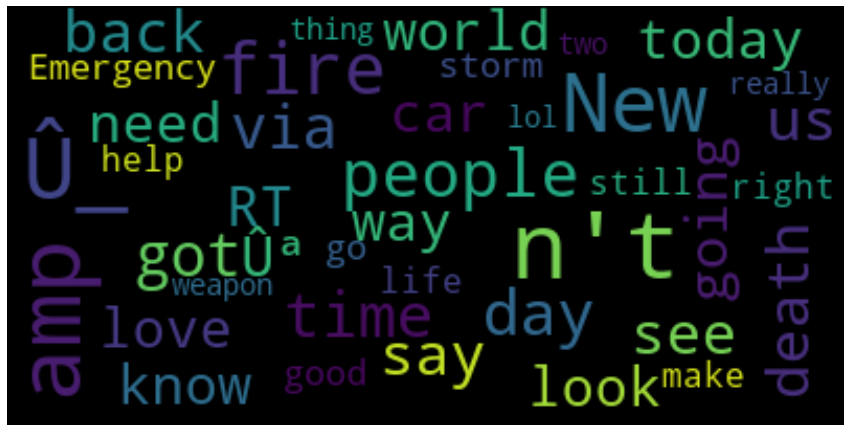

In [ ]:
text = train.text_clean.str.cat(sep=' ')
text_tokens = word_tokenize(text)
tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
tokens_filtered = (" ").join(tokens_without_sw)

from wordcloud import WordCloud
word_cloud = WordCloud(max_font_size=45, max_words=40,).generate(tokens_filtered)

# Display the generated WordCloud:
plt.figure(figsize=[15,9])
plt.imshow(word_cloud,interpolation="bilinear")
plt.axis("off")
plt.show()

In [23]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 5.5MB/s 


In [27]:
import tokenization
FullTokenizer = tokenization.FullTokenizer
#Configuring BERT tokenizer
BERT_MODEL_HUB = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(BERT_MODEL_HUB, trainable=True)  #Train on own dataset, hence trainable=True
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
tokenizer = FullTokenizer(vocabulary_file, to_lower_case)

print("Bert Tokenizer ready!")

Bert Tokenizer ready!


In [30]:
def tokenize_tweets(text_):
    return tokenizer.convert_tokens_to_ids(['[CLS]'] + tokenizer.tokenize(text_) + ['[SEP]'])

In [31]:
train['tokenized_tweets'] = train.text_clean.apply(lambda x: tokenize_tweets(x))
test['tokenized_tweets'] = test.text_clean.apply(lambda x: tokenize_tweets(x))

In [32]:
train.head()

,text,target,text_clean,hashtags,mentions,links,tokenized_tweets
0,Our Deeds are the Reason of this #earthquake M...,1,Deeds Reason earthquake May allah forgive PRON,earthquake,no,no,"[101, 15616, 3114, 8372, 2089, 16455, 9641, 40..."
1,Forest fire near La Ronge Sask. Canada,1,forest fire near La Ronge Sask Canada,no,no,no,"[101, 3224, 2543, 2379, 2474, 6902, 3351, 2187..."
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,no,no,no,"[101, 6319, 3198, 7713, 2173, 2025, 8757, 2961..."
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...,wildfires,no,no,"[101, 19527, 2692, 2111, 4374, 3748, 10273, 13..."
4,Just got sent this photo from Ruby #Alaska as ...,1,get send photo Ruby Alaska smoke wildfire pour...,Alaska wildfires,no,no,"[101, 2131, 4604, 6302, 10090, 7397, 5610, 374..."


In [33]:
test.head()

,text,text_clean,hashtags,mentions,links,tokenized_tweets
0,Just happened a terrible car crash,happen terrible car crash,no,no,no,"[101, 4148, 6659, 2482, 5823, 102]"
1,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe every...,earthquake,no,no,"[101, 2963, 8372, 2367, 2103, 2994, 3647, 3071..."
2,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee across street...,no,no,no,"[101, 3224, 2543, 3962, 8644, 28519, 10574, 24..."
3,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting Spokane wildfire,Spokane wildfires,no,no,"[101, 16976, 7497, 21878, 3748, 10273, 102]"
4,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kill 28 China Taiwan,no,no,no,"[101, 15393, 2061, 12672, 10626, 3102, 2654, 2..."


In [37]:
max1 = len(max(train.tokenized_tweets, key = len))
max2 = len(max(test.tokenized_tweets, key = len))
max_len = max(max1,max2)

train['padded_tweets'] = train.tokenized_tweets.apply(lambda x: x + [0] * (max_len - len(x)))
test['padded_tweets'] = test.tokenized_tweets.apply(lambda x: x + [0] * (max_len - len(x)))

In [38]:
train.head()

,text,target,text_clean,hashtags,mentions,links,tokenized_tweets,padded_tweets
0,Our Deeds are the Reason of this #earthquake M...,1,Deeds Reason earthquake May allah forgive PRON,earthquake,no,no,"[101, 15616, 3114, 8372, 2089, 16455, 9641, 40...","[101, 15616, 3114, 8372, 2089, 16455, 9641, 40..."
1,Forest fire near La Ronge Sask. Canada,1,forest fire near La Ronge Sask Canada,no,no,no,"[101, 3224, 2543, 2379, 2474, 6902, 3351, 2187...","[101, 3224, 2543, 2379, 2474, 6902, 3351, 2187..."
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,no,no,no,"[101, 6319, 3198, 7713, 2173, 2025, 8757, 2961...","[101, 6319, 3198, 7713, 2173, 2025, 8757, 2961..."
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...,wildfires,no,no,"[101, 19527, 2692, 2111, 4374, 3748, 10273, 13...","[101, 19527, 2692, 2111, 4374, 3748, 10273, 13..."
4,Just got sent this photo from Ruby #Alaska as ...,1,get send photo Ruby Alaska smoke wildfire pour...,Alaska wildfires,no,no,"[101, 2131, 4604, 6302, 10090, 7397, 5610, 374...","[101, 2131, 4604, 6302, 10090, 7397, 5610, 374..."


In [39]:
test.head()

,text,text_clean,hashtags,mentions,links,tokenized_tweets,padded_tweets
0,Just happened a terrible car crash,happen terrible car crash,no,no,no,"[101, 4148, 6659, 2482, 5823, 102]","[101, 4148, 6659, 2482, 5823, 102, 0, 0, 0, 0,..."
1,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe every...,earthquake,no,no,"[101, 2963, 8372, 2367, 2103, 2994, 3647, 3071...","[101, 2963, 8372, 2367, 2103, 2994, 3647, 3071..."
2,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee across street...,no,no,no,"[101, 3224, 2543, 3962, 8644, 28519, 10574, 24...","[101, 3224, 2543, 3962, 8644, 28519, 10574, 24..."
3,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting Spokane wildfire,Spokane wildfires,no,no,"[101, 16976, 7497, 21878, 3748, 10273, 102]","[101, 16976, 7497, 21878, 3748, 10273, 102, 0,..."
4,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kill 28 China Taiwan,no,no,no,"[101, 15393, 2061, 12672, 10626, 3102, 2654, 2...","[101, 15393, 2061, 12672, 10626, 3102, 2654, 2..."


**Building the Model:**

In [66]:
class TweetClassifier:
    
    def __init__(self, tokenizer, bert_layer, max_len, lr = 0.0001,
                 epochs = 15, batch_size = 32,
                 activation = 'sigmoid', optimizer = 'Adam',
                 beta_1=0.9, beta_2=0.999, epsilon=1e-07,
                 metrics = 'accuracy', loss = 'binary_crossentropy'):
        
        self.lr = lr
        self.epochs = epochs
        self.max_len = max_len
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.bert_layer = bert_layer
        

        self.activation = activation
        self.optimizer = optimizer
        
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon =epsilon
        
        self.metrics = metrics
        self.loss = loss

        
    def encode(self, texts):  #Tokenization, Padding, general processing of text is performed here
        
        all_tokens = []
        masks = []
        segments = []
        
        for text in texts:
            
            tokenized = self.tokenizer.convert_tokens_to_ids(['[CLS]'] + self.tokenizer.tokenize(text) + ['[SEP]'])            
            len_zeros = self.max_len - len(tokenized)            
            
            padded = tokenized + [0] * len_zeros

            #Bert requires 2 more params as inputs
            mask = [1] * len(tokenized) + [0] * len_zeros  
            segment = [0] * self.max_len
            
            all_tokens.append(padded)
            masks.append(mask)
            segments.append(segment)
        
        return np.array(all_tokens), np.array(masks), np.array(segments)


    def make_model(self):
        
        # Shaping the inputs to our model
        
        input_ids = Input(shape = (self.max_len, ), dtype = tf.int32, name = 'input_ids')        
        input_mask = Input(shape = (self.max_len, ), dtype = tf.int32, name = 'input_mask')        
        segment_ids = Input(shape = (self.max_len, ), dtype = tf.int32,  name = 'segment_ids')

        #Sequence output gives the embeddings of each word in a sentence
        pooled_output, sequence_output = bert_layer([input_ids, input_mask, segment_ids] )  


        clf_output = sequence_output[:, 0, :]   #First token embedding   
        dense1 = tf.keras.layers.Dense(16, activation=tf.keras.activations.sigmoid, use_bias=True)(clf_output)     
        out = tf.keras.layers.Dense(1, activation = self.activation)(dense1)       
        model = Model(inputs = [input_ids, input_mask, segment_ids], outputs = out)
        
        # define the optimizer

        if self.optimizer is 'SGD':
            optimizer = SGD(learning_rate = self.lr)

        elif self.optimizer is 'Adam': 
            optimizer = Adam(learning_rate = self.lr, beta_1=self.beta_1, beta_2=self.beta_2, epsilon=self.epsilon)

        model.compile(loss = self.loss, optimizer = self.optimizer, metrics = [self.metrics])
        
        print('Model is compiled with {} optimizer'.format(self.optimizer))
        
        return model
    
    
    
    
    def train(self, x):    
        
        checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)     
        
        model = self.make_model()
        
        X = self.encode(x['text_clean'])
        Y = x['target']
        
        model.fit(X, Y, shuffle = True, validation_split = 0.2, 
                  batch_size=self.batch_size, epochs = self.epochs,
                  callbacks=[checkpoint])
                
        print('Model is fit!')
        
            
    def predict(self, x):
        
        X_test_encoded = self.encode(x['text_clean'])
        best_model = tf.keras.models.load_model('model.h5',custom_objects={'KerasLayer':hub.KerasLayer})
        y_pred = best_model.predict(X_test_encoded)
        
        
        return y_pred

In [59]:
cleaned_train = train[['target','text_clean']]
cleaned_train.tail()

,target,text_clean
7608,1,two giant crane hold bridge collapse nearby home
7609,1,ariaahrary TheTawniest control wild fire Cali...
7610,1,M194 0104 UTC 5 km Volcano Hawaii
7611,1,Police investigate e bike collide car Little P...
7612,1,late home raze Northern California Wildfire AB...


In [60]:
cleaned_test = test[['text_clean']]
cleaned_test.tail()

,text_clean
3258,earthquake SAFETY LOS ANGELES ûò safety faste...
3259,storm ri bad last hurricane city amp 3others h...
3260,Green Line derailment Chicago
3261,MEG issue Hazardous Weather Outlook HWO
3262,CityofCalgary activate Municipal Emergency Pl...


In [67]:
classifier = TweetClassifier(tokenizer = tokenizer, bert_layer = bert_layer,
                              max_len = max_len, lr = 0.0001,
                              epochs = 15,  activation = 'sigmoid',
                              batch_size = 32,optimizer = 'SGD',
                              beta_1=0.9, beta_2=0.999, epsilon=1e-07)

In [68]:
classifier.train(cleaned_train)

Model is compiled with SGD optimizer
Epoch 1/15
191/191 [==============================] - 73s 384ms/step - loss: 0.6860 - accuracy: 0.5626 - val_loss: 0.6958 - val_accuracy: 0.5345
Epoch 2/15
191/191 [==============================] - 72s 378ms/step - loss: 0.6815 - accuracy: 0.5793 - val_loss: 0.7006 - val_accuracy: 0.5345
Epoch 3/15
191/191 [==============================] - 72s 379ms/step - loss: 0.6815 - accuracy: 0.5793 - val_loss: 0.6994 - val_accuracy: 0.5345
Epoch 4/15
191/191 [==============================] - 72s 379ms/step - loss: 0.6813 - accuracy: 0.5793 - val_loss: 0.6959 - val_accuracy: 0.5345
Epoch 5/15
191/191 [==============================] - 72s 378ms/step - loss: 0.6807 - accuracy: 0.5793 - val_loss: 0.6990 - val_accuracy: 0.5345
Epoch 6/15
191/191 [==============================] - 74s 388ms/step - loss: 0.6814 - accuracy: 0.5793 - val_loss: 0.6937 - val_accuracy: 0.5345
Epoch 7/15
191/191 [==============================] - 72s 379ms/step - loss: 0.6812 - accurac

In [70]:
y_pred = np.round(classifier.predict(cleaned_test))
sample_sub = pd.read_csv('sample_submission.csv')
ids = sample_sub.id
final_submission = pd.DataFrame(np.c_[ids, y_pred.astype('int')], columns = ['id', 'target'])
final_submission.to_csv('final_submission.csv', index = False)
final_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
